In [1]:
from itertools import chain

import pandas as pd
import sqlite3
from sklearn.cross_decomposition import PLSCanonical
from sklearn.mixture import BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy as sp
from matplotlib import animation
from IPython.display import HTML

## Constants

In [2]:
color_map = {'acarbose': 'goldenrod', 'control': 'darkblue',
             'UM': 'darkblue', 'UT': 'darkgreen',
             'male': 'blue', 'female': 'magenta',
             'C2013': 'blue', 'Glenn': 'red'}

## Load Data

In [3]:
# Select the data

con = sqlite3.connect('data/core.1.denorm.db')

# Relative Abundance
rrs_count = (pd.read_sql('SELECT * FROM rrs_taxon_count;',
                         con=con, index_col=['extraction_id', 'sequence_id'])
               .tally.unstack().fillna(0).astype(int))
rabund = rrs_count.apply(lambda x: x / x.sum(), axis=1)

# Coverage
bin_cvrg = (pd.read_sql("""
SELECT bin_id, extraction_id, SUM(coverage) AS coverage
FROM bin_coverage
JOIN library USING (library_id)
GROUP BY bin_id, extraction_id;""",
                        con=con, index_col=['extraction_id', 'bin_id'])
              .coverage.unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1))

# Only keep shared extractions
extractions = set(rabund.index) & set(bin_cvrg.index)
rabund = rabund.loc[extractions]
bin_cvrg = bin_cvrg.loc[extractions]

# Phylotypes
phylotype = pd.read_sql('SELECT sequence_id, otu_id FROM rrs_taxon_count GROUP BY sequence_id;',
                       con=con, index_col='sequence_id')
name_map = {}
for otu, d in (pd.DataFrame({'mean_rabund': rabund.mean(),
                             'otu_id': phylotype.otu_id})
                 .sort_values('mean_rabund',
                              ascending=False)
                 .groupby('otu_id')):
    for i, sequence_id in enumerate(d.index, start=1):
        name_map[sequence_id] = '{}_{}'.format(otu, i)
phylotype['name'] = pd.Series(name_map)
phylotype['mean_rabund'] = rabund.mean()

contig_bin = pd.read_sql("SELECT * FROM contig_bin", con=con, index_col='contig_id')

In [4]:
library = pd.read_table('meta/library.tsv', index_col='library_id')

## OTU Details

In [5]:
taxonomy = pd.read_sql('SELECT sequence_id, phylum_, class_, order_, family_, genus_ FROM rrs_taxonomy;',
                       con=con, index_col='sequence_id').rename(phylotype.name)

In [6]:
# Select abundant taxa and bins
# TODO: Set these threshold as parameters
major_taxa = phylotype.index[phylotype.mean_rabund > 0.0001]
major_bins = bin_cvrg.columns[bin_cvrg.mean() > 0.0001]
d_rabund = rabund[major_taxa].copy()
d_rabund['other'] = rabund.drop(columns=major_taxa).sum(1)
d_rabund.rename(columns=phylotype.name, inplace=True)
d_cvrg = bin_cvrg[major_bins].copy()
d_cvrg['other'] = bin_cvrg.drop(columns=major_bins).sum(1)

d_rabund.shape, d_cvrg.shape

((58, 454), (58, 1165))

In [7]:
d_rabund.mean().to_frame(name='mean_rabund').join(taxonomy).sort_values('mean_rabund', ascending=False)[lambda x: x.family_ == 'Muribaculaceae'].head(25)

,mean_rabund,phylum_,class_,order_,family_,genus_
sequence_id,,,,,,
Otu0001_1,0.108943,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0001_2,0.051310,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0007_1,0.039760,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0009_1,0.026249,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0005_1,0.023848,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0004_1,0.017213,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0007_2,0.014037,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0001_3,0.006326,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge
Otu0001_4,0.005917,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae_ge


## Metabinning

In [8]:
pls_fit = PLSCanonical(scale=False, n_components=40).fit(d_cvrg.apply(np.sqrt), d_rabund.apply(np.sqrt))
bin_otu_contrib = pd.DataFrame((pls_fit.x_loadings_ @ pls_fit.y_loadings_.T),
                       index=d_cvrg.columns, columns=d_rabund.columns).rename(columns=phylotype.name)

52
Otu0001_1 0.43218920562851776
Otu0001_2 0.5725852168812455
Otu0001_3 0.3028815625396847
Otu0001_4 0.15086632268626132
Otu0002_1 0.4852137197133138
Otu0003_1 0.5474693942374066
Otu0004_1 0.34163124888250684
Otu0004_2 0.19713684637506115
Otu0005_1 0.37186655734961066
Otu0006_1 0.3808006636527149
Otu0007_1 0.2700837101833019
Otu0007_2 0.2505419575617553
Otu0009_1 0.24600743336080813
Otu0012_1 0.1398412638279287
Otu0013_1 0.10082124370267485
Otu0015_1 0.16036358340867168
Otu0017_1 0.1756753409694695
Otu0019_1 0.12238424616725985
Otu0020_1 0.10233674619403038
Otu0021_1 0.08007983979004706
Otu0023_1 0.08520641545958788
Otu0023_2 0.057358875821224224
Otu0024_1 0.13873308412045576
Otu0025_1 0.2358503342223567
Otu0026_1 0.07620837569824941
Otu0027_1 0.20386125409926512
Otu0028_1 0.10251310258317983
Otu0029_1 0.06764631608286857
Otu0030_1 0.09786999588309364
Otu0031_1 0.07197946079493696
Otu0032_1 0.17012726749910365
Otu0033_1 0.24736860093992358
Otu0034_1 0.08977389023409205
Otu0035_1 0.2684

/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


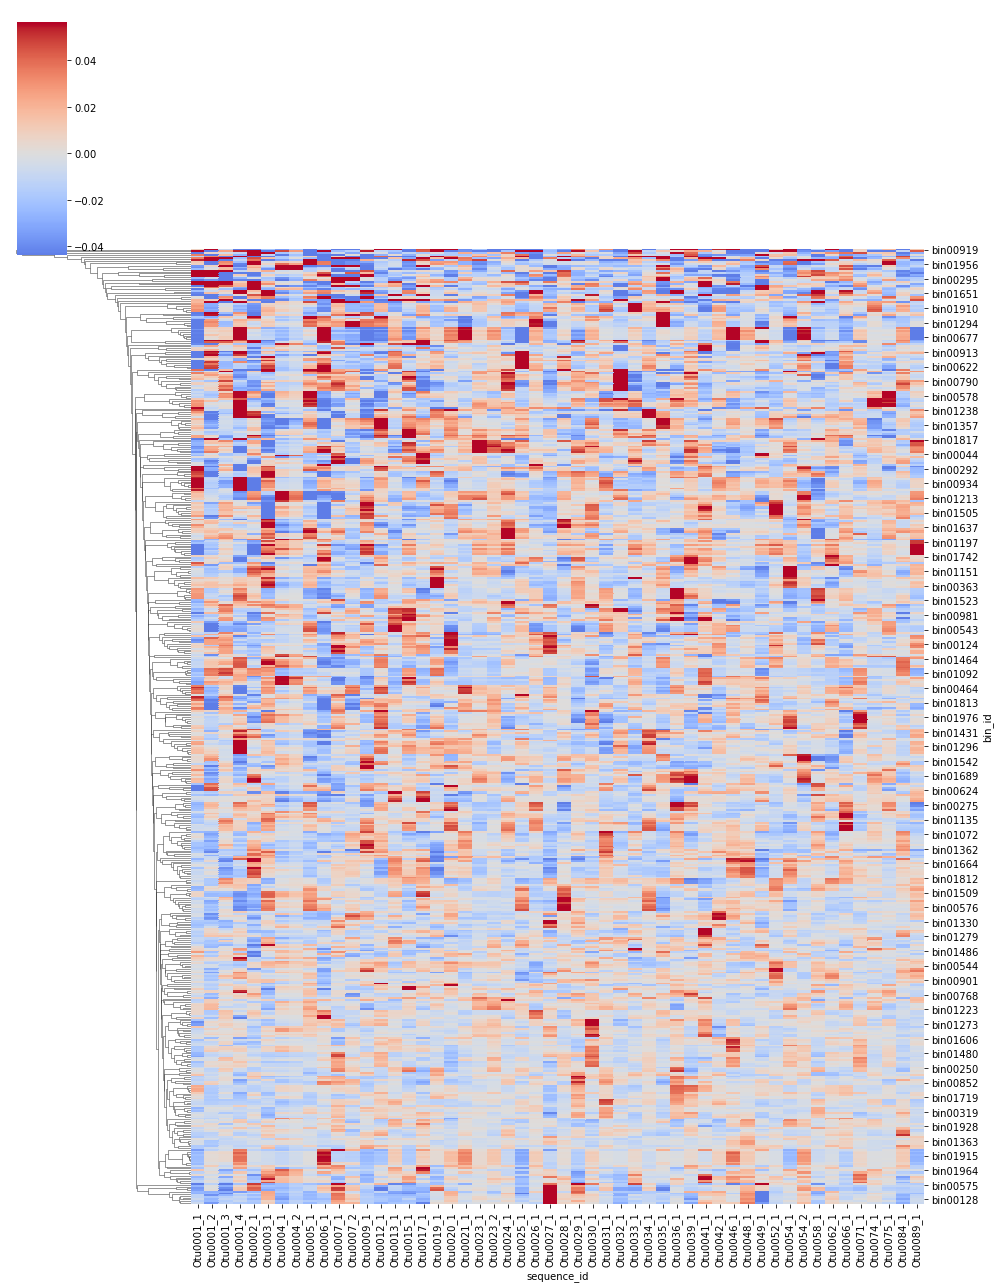

In [9]:
tax_filter = lambda x: x.quantile(0.95) > 0.01

taxa_of_interest = sorted(d_rabund.loc[:, tax_filter].rename(columns=phylotype.name).columns)
if 'other' in taxa_of_interest:
    del taxa_of_interest[taxa_of_interest.index('other')]
print(len(taxa_of_interest))



factor = 1/3

_hits = {}
for tax in taxa_of_interest:
    top_score = bin_otu_contrib[tax].max()
    print(tax, top_score)
    _hits[tax] = list((bin_otu_contrib[tax].sort_values(ascending=False) > top_score * factor)[lambda x: x].index)
    
print()
for tax in _hits:
    print(tax, _hits[tax])

all_hits = set(chain(*_hits.values()))

a = sns.clustermap(bin_otu_contrib.loc[all_hits, taxa_of_interest].rename(columns=phylotype.name), robust=True,
                   figsize=(14, 18), col_cluster=False, cmap='coolwarm', center=0)

ax = a.fig.get_axes()[2]
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

print()

## Metabin Refinement

### B1 / OTU-1 / Otu0001

In [10]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/3
otus = ['Otu0001_1', 'Otu0001_2', 'Otu0001_3',
        'Otu0001_4', 'Otu0001_5'
       ]
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin01238', 'bin00578', 'bin00913', 'bin01765', 'bin00480', 'bin01251', 'bin01956', 'bin00557', 'bin00661', 'bin00324', 'bin00224', 'bin00400', 'bin01539', 'bin00737', 'bin01817', 'bin00042', 'bin01668', 'bin01611', 'bin00924', 'bin00276', 'bin00914', 'bin00004', 'bin00156', 'bin01526', 'bin00062', 'bin01803', 'bin00710', 'bin00508', 'bin00904', 'bin01843', 'bin00919', 'bin00281', 'bin00683', 'bin00254', 'bin00560', 'bin01181', 'bin00934', 'bin00906', 'bin01011', 'bin01381', 'bin00472', 'bin00457', 'bin01296', 'bin01452', 'bin00677', 'bin01307', 'bin00378', 'bin01814', 'bin01651', 'bin00684', 'bin00529', 'bin00708', 'bin01684', 'bin00008', 'bin00623', 'bin00143', 'bin00483', 'bin01585', 'bin01963', 'bin00629', 'bin01431'}


In [11]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [12]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0001_1,Otu0001_2,Otu0001_3,Otu0001_4,Otu0001_5
site,,,,,
UM,0.153058,0.069344,0.000097,0.010070,0.000728
UT,0.046447,0.025763,0.015149,0.000035,0.000032


In [13]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin00378'].sort_values('length', ascending=False).head()

,bin_id,length
contig_id,,
536619,bin00378,100866
434939,bin00378,76561
301857,bin00378,75428
1830468,bin00378,70080
171591,bin00378,63054


#### Normalization

119 trusted contigs and 56 trusted extractions identified


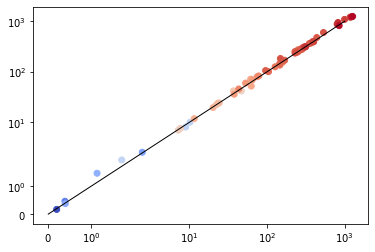

In [14]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '536619', '1830468',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


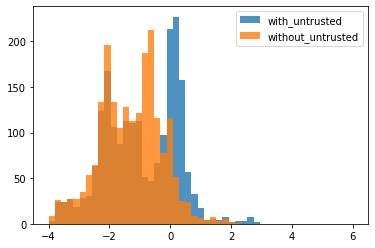

In [15]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-16-3f2109768a29>:60: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


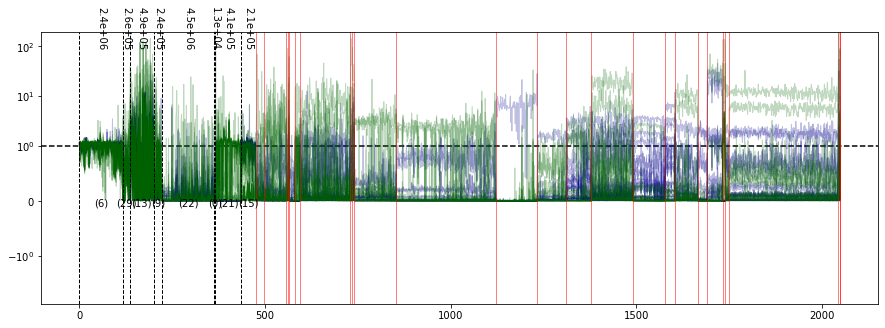

In [16]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=40,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              max_iter=int(1e3),
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 35
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)

ax.set_yscale('symlog', linthreshy=1)

In [17]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int).T

bin_id,bin00004,bin00008,bin00042,bin00062,bin00143,bin00156,bin00224,bin00254,bin00276,bin00281,...,bin01651,bin01668,bin01684,bin01765,bin01803,bin01814,bin01817,bin01843,bin01956,bin01963
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8960,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,69822,0,0,0,0,0,0
13,0,2323,8218,0,5666,0,0,0,0,0,...,0,0,0,93463,0,0,0,0,76589,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1112,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4178,0,0,0,0,0,0
22,40423,11936,0,0,37748,0,0,1524,13814,211344,...,10789,0,0,3266,0,3799467,2868,0,2900,0
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2212,0,0,0,0,0,0
contam,1786034,3430306,0,62621,4419033,1752,61643,80354,0,0,...,1659477,79223,265096,23732,555872,0,43237,21167,2735237,149835


In [18]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UM    acarbose     17
      control      17
UT    acarbose     10
      control      12
Name: 1000427, dtype: int64


site             UM                  UT          
treatment  acarbose   control  acarbose   control
group                                            
0          0.341326  0.352267  0.303368  0.187247
6          1.035852  1.028828  0.980626  1.009103
9          0.114571  0.159641  0.528882  0.689913
13         1.259108  1.614498  3.871744  2.689791
15         1.033039  1.051953  0.547734  0.399653
21         0.000909  0.002520  0.764314  0.743852
22         0.033712  0.063816  0.144628  0.089898
29         0.548811  0.556039  0.647408  0.621235

<ipython-input-19-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-19-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


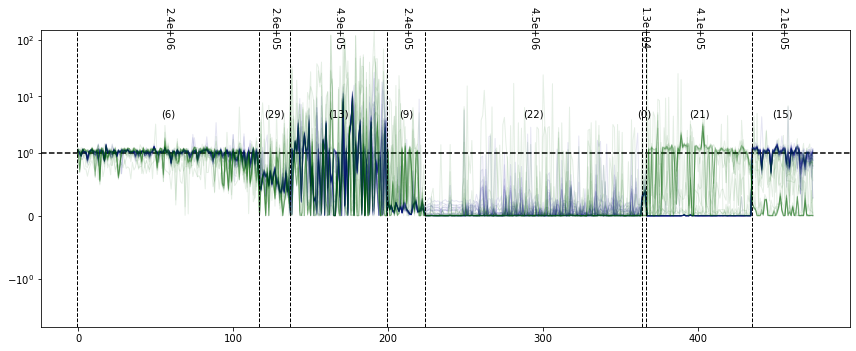

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [20]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-21-1d4e36034e71>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
<ipython-input-21-1d4e36034e71>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,
<ipython-input-21-1d4e36034e71>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,


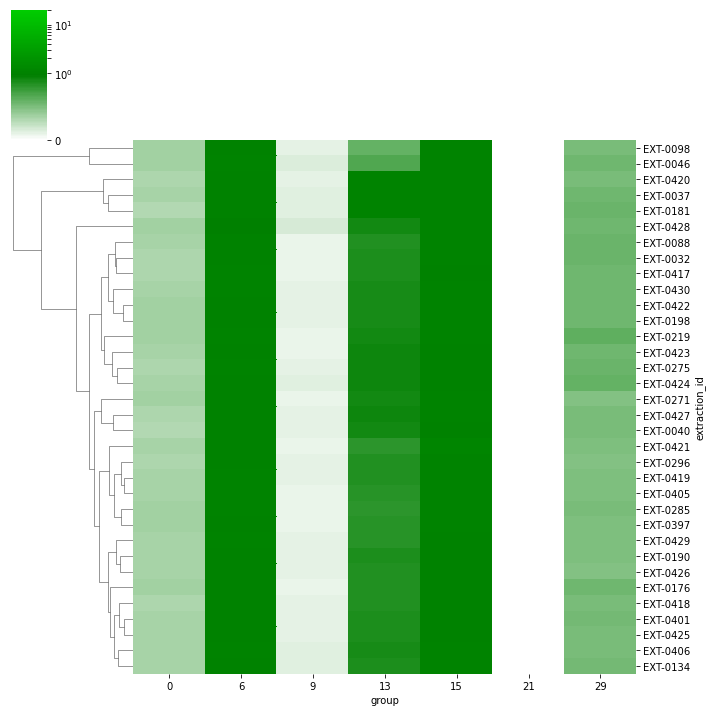

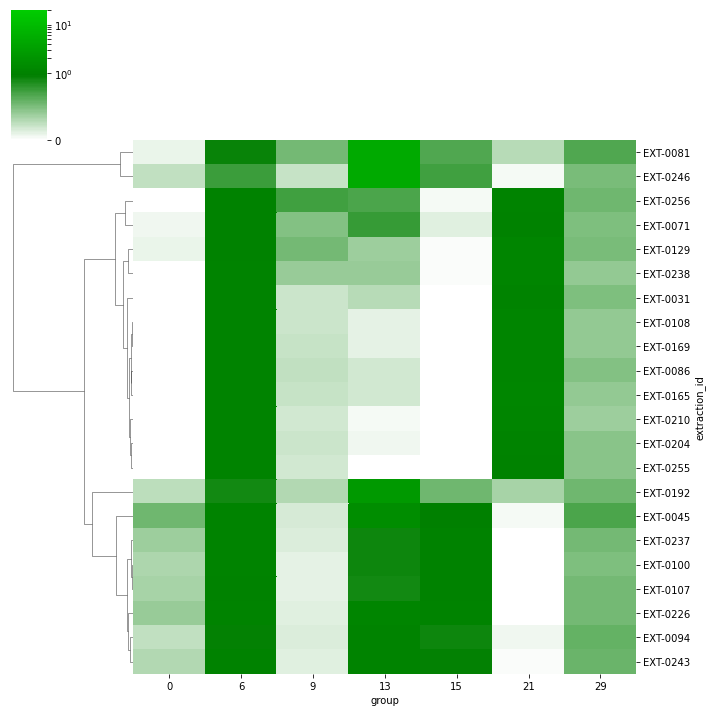

In [21]:
# INSTRUCTION: Pick groups you want to drop from visualization.
# INSTRUCTION: Pick a linscale that best contrasts enriched and depleted groups.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[22, ]))

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm)


#### Curation

In [22]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

# "UM" Strain
with open('chkpt/core.a.mags/B1A.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([0, 6, 9, 13, 15, 29])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B1A.g.library.list', 'w') as handle:
    extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UM'].index))
    extraction_ids -= set([])
    extraction_ids |= set(['EXT-0237', 'EXT-0226', 'EXT-0243', 'EXT-0045', 'EXT-0100', 'EXT-0094', 'EXT-0107'
                          ])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B1A.g.trusted_depth.tsv', sep='\t', header=False)

# UT Strain
with open('chkpt/core.a.mags/B1B.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([6, 9, 13, 21, 29])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B1B.g.library.list', 'w') as handle:
    extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UT'].index))
    extraction_ids -= set(['EXT-0237', 'EXT-0226', 'EXT-0243', 'EXT-0045', 'EXT-0100', 'EXT-0094', 'EXT-0107',
                           'EXT-0081','EXT-0246', 'EXT-0192'])
#    extraction_ids |= set(['EXT-0421'])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B1B.g.trusted_depth.tsv', sep='\t', header=False)

<ipython-input-22-dac9d4eea8f1>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UM'].index))
<ipython-input-22-dac9d4eea8f1>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UT'].index))


### B2 / OTU-4 / Otu0007

In [23]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/4
otus = ['Otu0007_1', 'Otu0007_2']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin01948', 'bin00499', 'bin00295', 'bin01568', 'bin01727', 'bin00840', 'bin00280', 'bin00737', 'bin00575', 'bin01611', 'bin01974', 'bin00225', 'bin00483', 'bin01294', 'bin00561'}


In [24]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [25]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0007_1,Otu0007_2
site,,
UM,0.000022,0.000008
UT,0.096056,0.033912


In [26]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin00225'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
1147395,bin00225,252664
1695905,bin00225,194067
2249288,bin00225,130664
795567,bin00225,129828
35357,bin00225,127085
1023797,bin00225,113310
813155,bin00225,103573
327312,bin00225,99633
131507,bin00225,98443


#### Normalization

76 trusted contigs and 24 trusted extractions identified


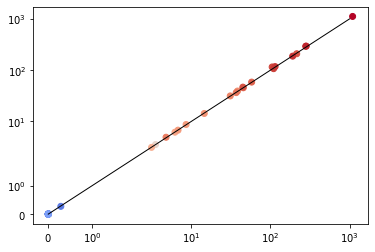

In [27]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '35357', '1023797',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


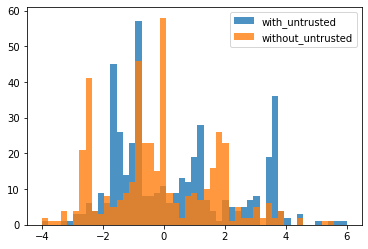

In [28]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-29-4024cb3710d0>:59: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


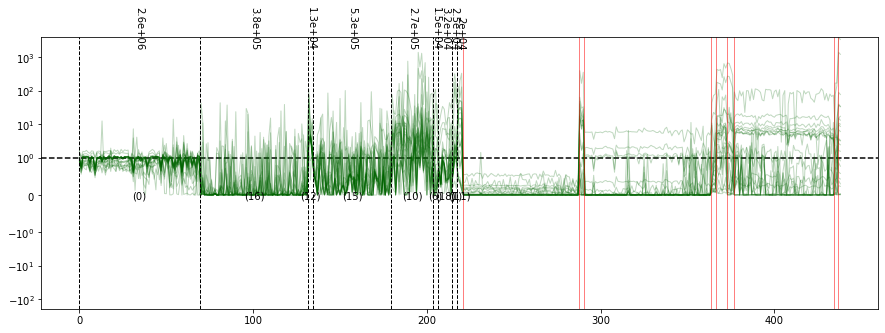

In [29]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=20,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 50
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)

ax.set_yscale('symlog', linthreshy=1)

In [30]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,0,1,6,10,11,12,15,16,18,contam
bin_id,,,,,,,,,,
bin00225,2548480,0,0,169649,0,4271,328885,18081,17625,4236
bin00280,0,0,14089,14327,0,0,81336,120737,1230,2698630
bin00295,29454,0,0,2929,0,0,38403,2922,12741,0
bin00483,0,0,0,0,0,0,3690,0,0,148756
bin00499,0,0,0,0,0,0,0,0,0,38359
bin00561,0,0,0,8262,0,0,0,103534,0,0
bin00575,0,0,0,0,0,0,0,53592,0,0
bin00737,3468,7725,0,3159,0,0,1175,24228,0,0
bin00840,0,0,0,41511,0,0,62341,0,0,0


In [31]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UT    acarbose     12
      control      12
Name: 1014433, dtype: int64


site             UT           
treatment  acarbose    control
group                         
0          0.984026   0.935146
1          7.917103  21.986779
6          1.281863   8.493465
10         6.903092  31.189908
11         5.335687  41.137277
12         5.352554  10.198977
15         1.389422   1.083871
16         0.451141   0.449073
18         0.671617   3.981274

<ipython-input-32-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-32-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


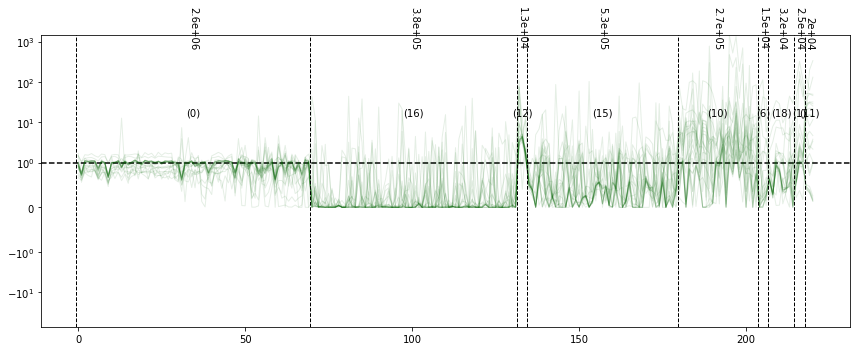

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [33]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-34-809a636fb313>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


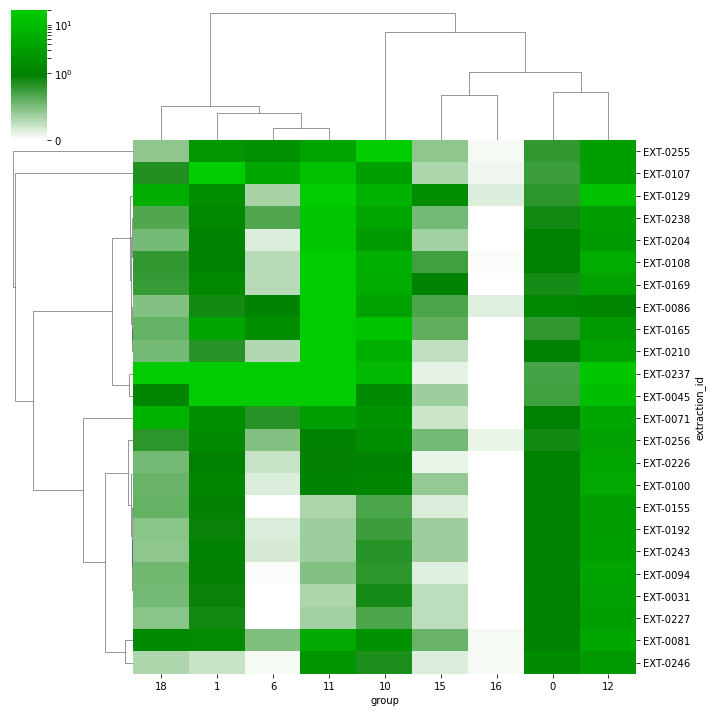

In [34]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

# sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
#                col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d, vmin=vmin, vmax=vmax,
               col_cluster=True, robust=True, cmap=cmap, norm=norm, metric='cosine')

#### Curation

In [35]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

with open('chkpt/core.a.mags/B2.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([12, 15, 0, 18])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B2.g.library.list', 'w') as handle:
    extraction_ids = set(trusted_extractions)
    extraction_ids -= set([])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B2.g.trusted_depth.tsv', sep='\t', header=False)

### B3 / OTU-8 / Otu0009

In [36]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/3
otus = ['Otu0009_1']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin00965', 'bin00480', 'bin00800'}


In [37]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [38]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0009_1
site,
UM,0.044194
UT,0.000826


In [39]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin00800'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
3207687,bin00800,19179
3026612,bin00800,12476
1621700,bin00800,9123
2880790,bin00800,3280
2662447,bin00800,2415


#### Normalization

49 trusted contigs and 39 trusted extractions identified


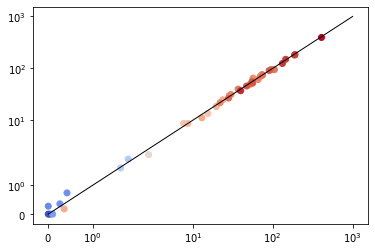

In [40]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '1621700', '2880790',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


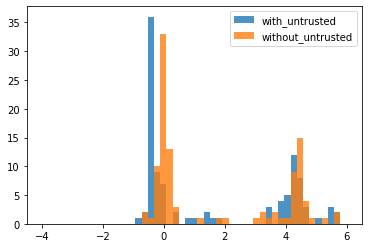

In [41]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-42-44c03fea40a9>:59: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


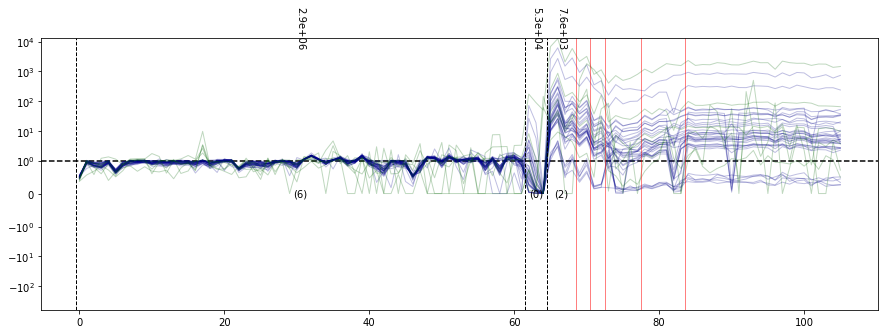

In [42]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=10,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 50
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)

ax.set_yscale('symlog', linthreshy=1)

In [43]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,0,2,6,contam
bin_id,,,,
bin00480,49388,7608,0,270045
bin00800,0,0,46473,0
bin00965,3589,0,2810781,0


In [44]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UM    acarbose     17
      control      16
UT    acarbose      4
      control       2
Name: 100100, dtype: int64


site               UM                      UT           
treatment    acarbose    control     acarbose    control
group                                                   
0            3.025628   0.187901    26.784916  34.308202
2          337.094936  21.245186  1819.276105  19.834378
6            0.959494   0.975259     0.956854   1.136578

<ipython-input-45-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-45-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


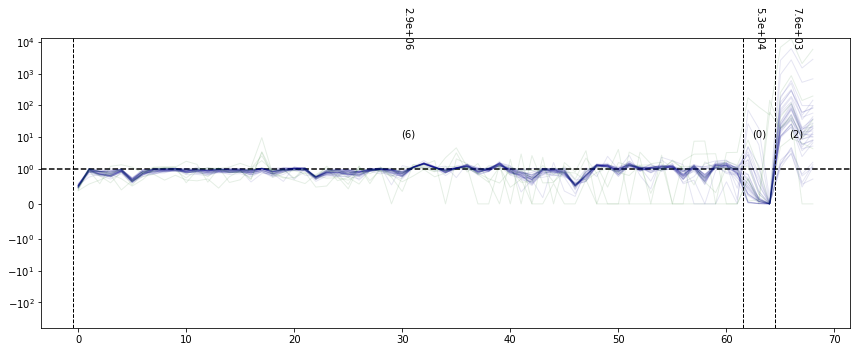

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [46]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-47-1523cfb4922c>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=0.9)
<ipython-input-47-1523cfb4922c>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,
<ipython-input-47-1523cfb4922c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,

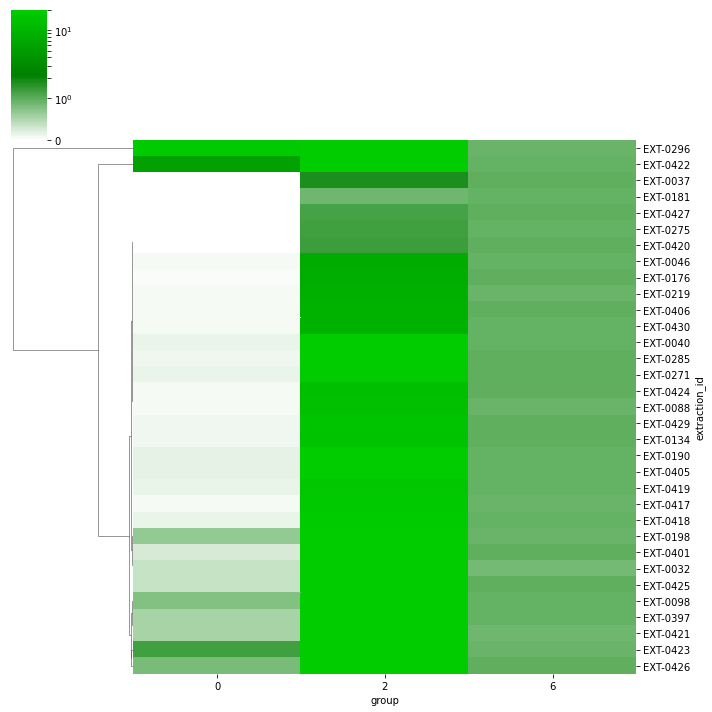

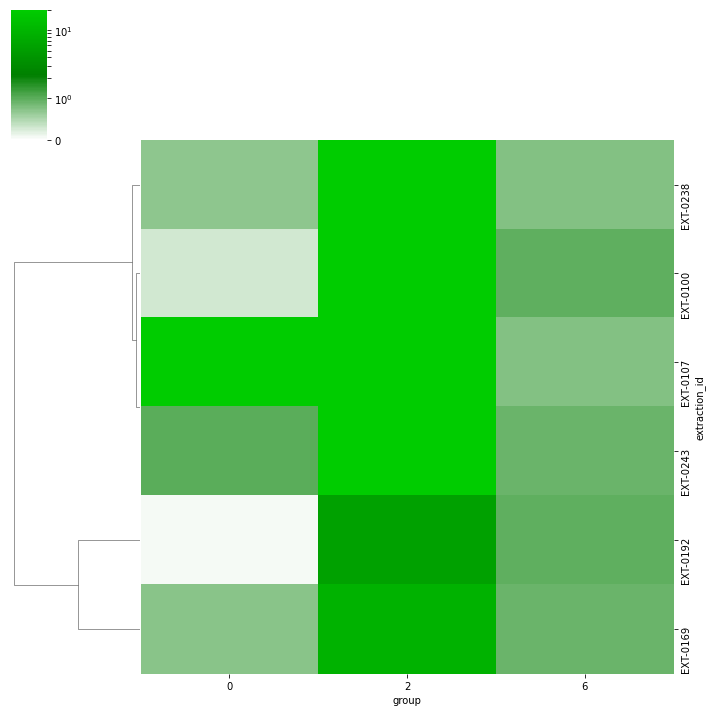

In [47]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=0.9)

sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm, metric='cosine')


#### Curation

In [48]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

with open('chkpt/core.a.mags/B3.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([6])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B3.g.library.list', 'w') as handle:
    extraction_ids = set(trusted_extractions)
    extraction_ids -= set([])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B3.g.trusted_depth.tsv', sep='\t', header=False)

### B4 / OTU-5 / Otu0005

In [49]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/3
otus = ['Otu0005_1']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin01668', 'bin01956', 'bin01539'}


In [50]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [51]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0005_1
site,
UM,0.040238
UT,0.000628


In [52]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin01956'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
2140623,bin01956,312638
156806,bin01956,232160
975110,bin01956,229565
1943938,bin01956,222540
3947283,bin01956,171575
607404,bin01956,169234
1282467,bin01956,136284
1514189,bin01956,127796
2373550,bin01956,125727


#### Normalization

29 trusted contigs and 40 trusted extractions identified


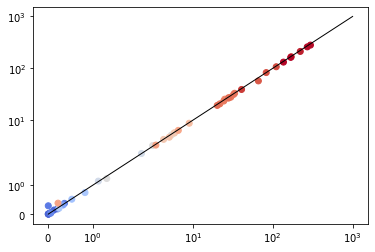

In [53]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '156806', '2140623',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.95
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


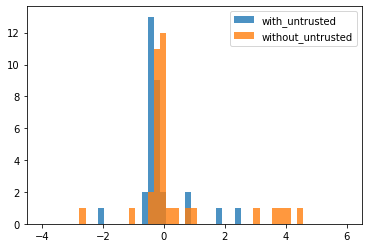

In [54]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-55-44c03fea40a9>:59: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


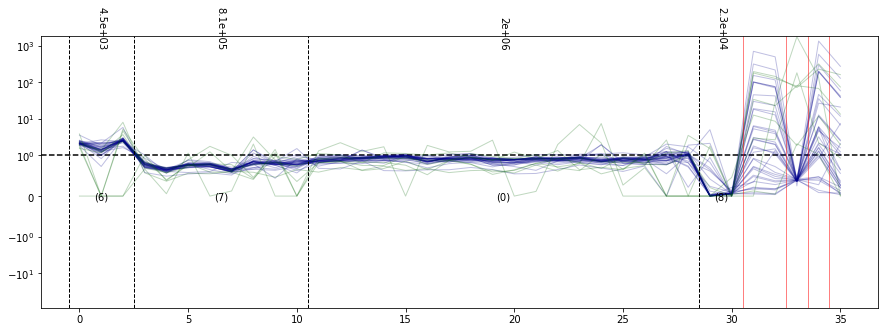

In [55]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=10,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 50
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)

ax.set_yscale('symlog', linthreshy=1)

In [56]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,0,6,7,8,contam
bin_id,,,,,
bin01539,0,0,0,20438,54245
bin01668,0,0,79223,0,0
bin01956,1999900,4504,734114,2900,73308


In [57]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UM    acarbose     17
      control      16
UT    acarbose      3
      control       4
Name: 113465, dtype: int64


site             UM                  UT          
treatment  acarbose   control  acarbose   control
group                                            
0          0.926658  0.909714  0.958235  0.964076
6          2.109131  2.173563  1.932257  1.988660
7          0.749095  0.763056  0.744375  0.710081
8          0.170625  0.260065  0.637180  0.030838

<ipython-input-58-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-58-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


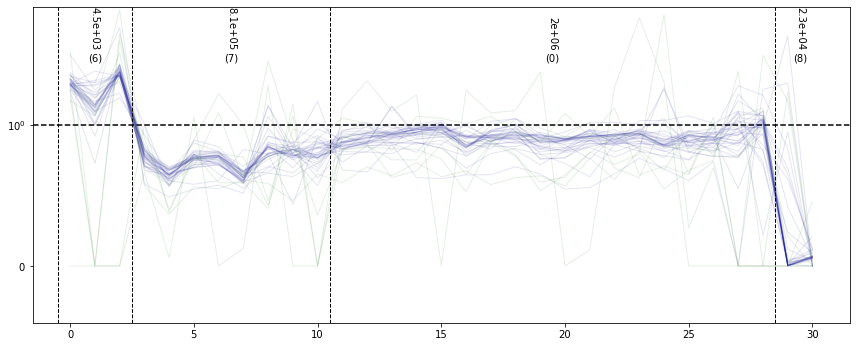

In [58]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [59]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-60-05c990a47bcc>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
<ipython-input-60-05c990a47bcc>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,
<ipython-input-60-05c990a47bcc>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,


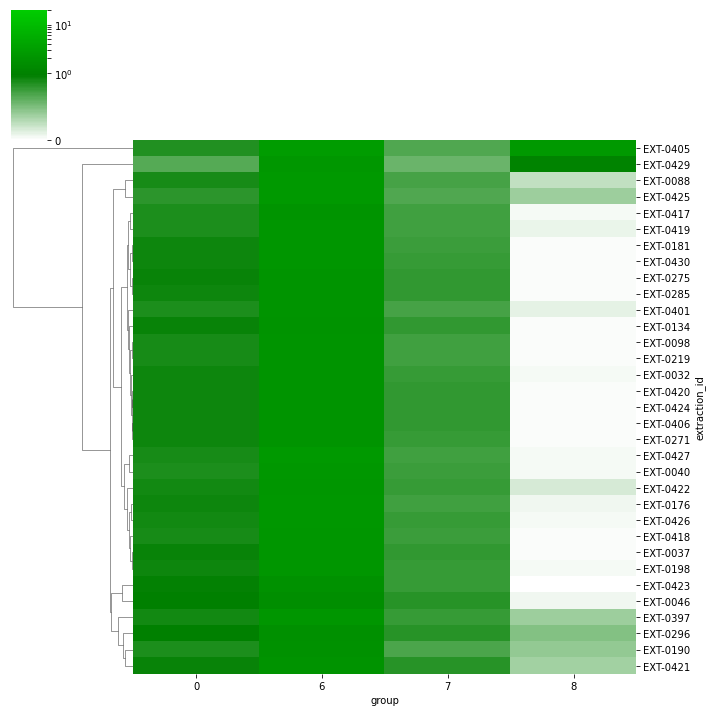

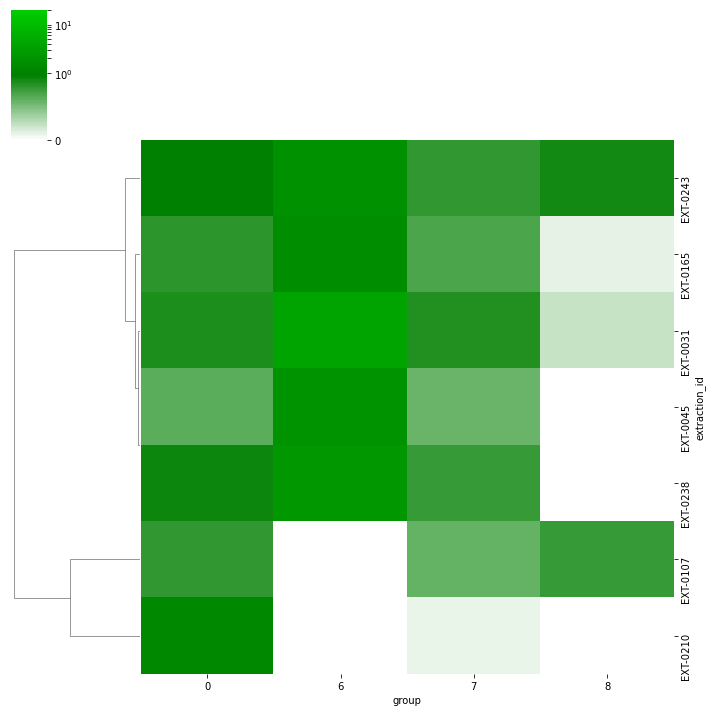

In [60]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm, metric='cosine')


#### Curation

In [61]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

with open('chkpt/core.a.mags/B4.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([0, 6, 7])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B4.g.library.list', 'w') as handle:
    extraction_ids = set(trusted_extractions)
    extraction_ids -= set(['EXT-0107', 'EXT-0210'])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B4.g.trusted_depth.tsv', sep='\t', header=False)

### B5 / OTU-6 / Otu0004

In [62]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/3
otus = ['Otu0004_1', 'Otu0004_2']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin01727', 'bin01354', 'bin01906'}


In [63]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [64]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0004_1,Otu0004_2
site,,
UM,0.000021,0.000004
UT,0.041568,0.013832


In [65]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin01354'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
3759879,bin01354,223644
377349,bin01354,205618
586388,bin01354,147020
507616,bin01354,100402
1560989,bin01354,94435
1789476,bin01354,80950
1537086,bin01354,66867
1037223,bin01354,58955
383765,bin01354,53952


#### Normalization

86 trusted contigs and 26 trusted extractions identified


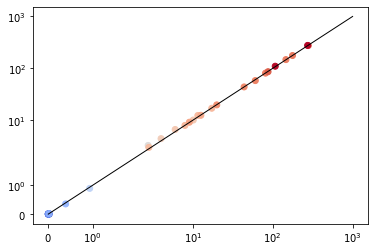

In [66]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '3759879', '586388',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


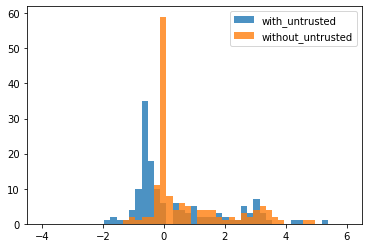

In [67]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-68-4024cb3710d0>:59: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


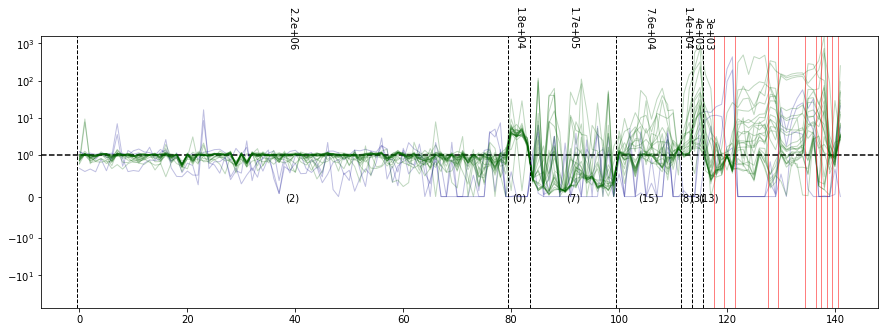

In [68]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=20,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 50
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)

ax.set_yscale('symlog', linthreshy=1)

In [69]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,0,2,3,7,8,13,15,contam
bin_id,,,,,,,,
bin01354,5147,2157755,0,122103,0,1105,41430,127512
bin01727,13105,0,4033,32883,14377,0,22164,75539
bin01906,0,24802,0,15274,0,1925,12601,0


In [70]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UM    acarbose      2
      control       1
UT    acarbose     11
      control      12
Name: 1019606, dtype: int64


site             UM                    UT          
treatment  acarbose   control    acarbose   control
group                                              
0          0.074675  0.009581    3.582539  4.681106
2          1.058447  1.017633    0.981240  0.988208
3          3.300693  1.132796  160.462331  9.391899
7          0.897376  1.295909    6.744639  0.656065
8          0.035307  0.000000   13.450281  2.502913
13         8.933973  9.967473   13.226346  0.869802
15         0.873377  0.793559    4.674483  1.642229

<ipython-input-71-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-71-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


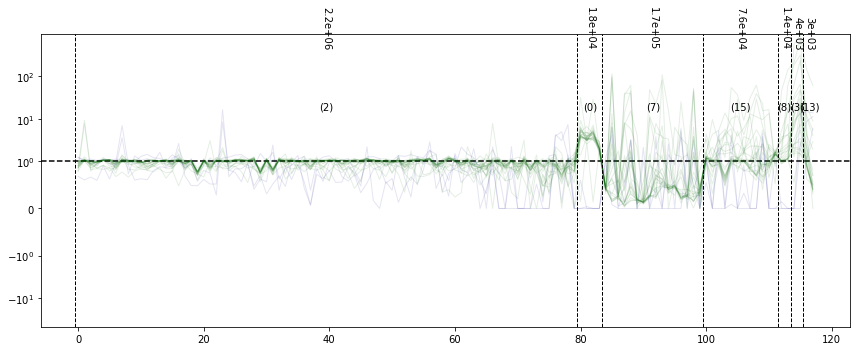

In [71]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [72]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-73-05c990a47bcc>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
<ipython-input-73-05c990a47bcc>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,
<ipython-input-73-05c990a47bcc>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,


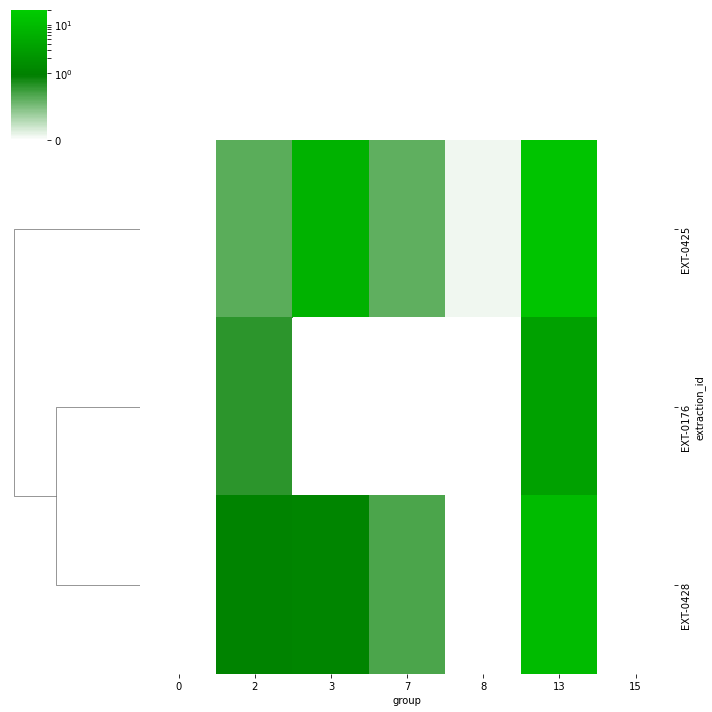

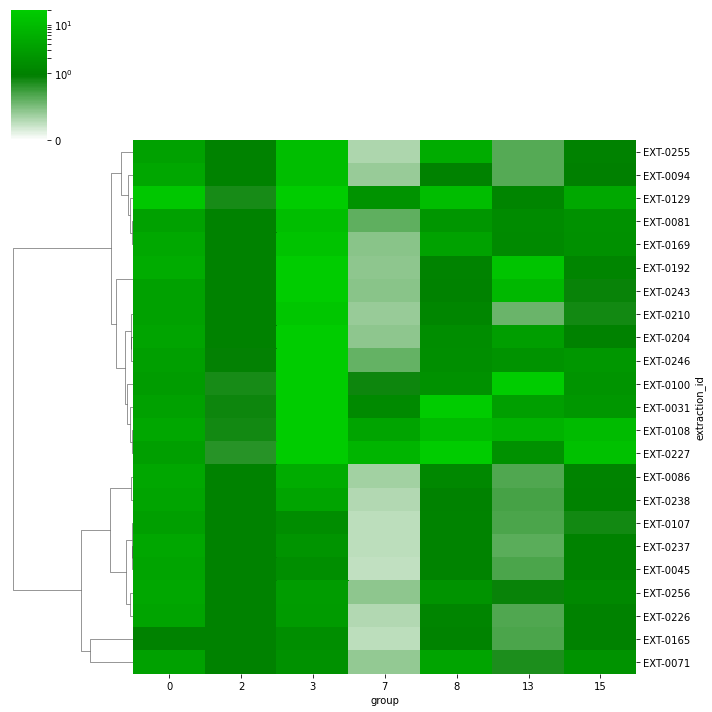

In [73]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm, metric='cosine')


#### Curation

In [74]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

# UT Strain
with open('chkpt/core.a.mags/B5.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([0, 2, 7, 8, 13, 15])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B5.g.library.list', 'w') as handle:
    extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UT'].index))
    extraction_ids -= set([])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B5.g.trusted_depth.tsv', sep='\t', header=False)

<ipython-input-74-de79bda1dfce>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UT'].index))


### B6 / OTU-39 / Otu0049

In [75]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/5
otus = ['Otu0049_1']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin00231', 'bin00959', 'bin00661', 'bin01084', 'bin01906', 'bin00892', 'bin00305', 'bin00840', 'bin00501', 'bin00575', 'bin01484', 'bin01992', 'bin00044', 'bin00789', 'bin01324', 'bin01370'}


In [76]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [77]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0049_1
site,
UM,0.000001
UT,0.010753


In [78]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin01484'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
330333,bin01484,20526
3176163,bin01484,17393
2985722,bin01484,12688
975319,bin01484,12313


#### Normalization

72 trusted contigs and 10 trusted extractions identified


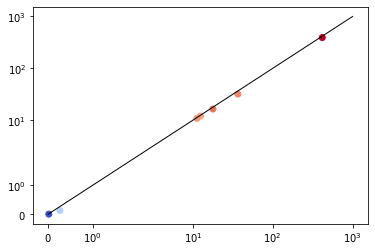

In [79]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '975319', '3176163',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


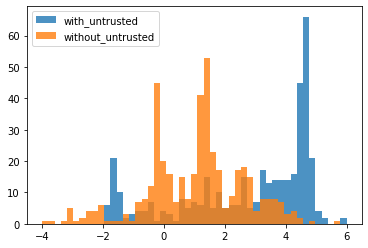

In [80]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-81-c04902a77250>:59: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


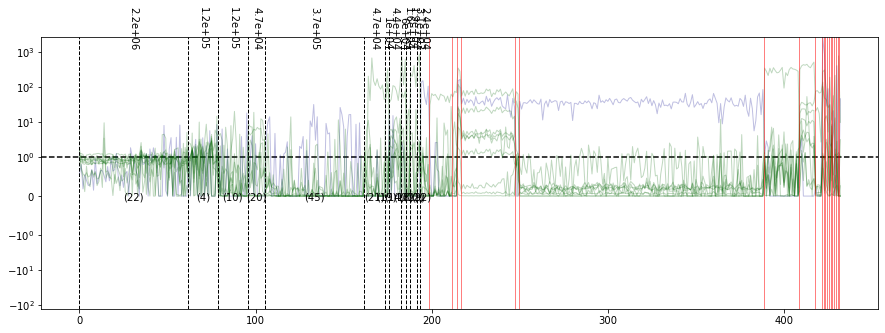

In [81]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=50,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 80
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)

ax.set_yscale('symlog', linthreshy=1)

In [82]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,2,4,9,10,12,14,18,19,20,21,22,32,45,contam
bin_id,,,,,,,,,,,,,,
bin00044,0,1073,0,37231,0,0,0,0,9608,0,6952,0,0,0
bin00231,0,83494,3064,60277,4112,1371,1020,10355,7557,47193,2156783,16171,40834,341473
bin00305,0,0,0,0,0,0,0,0,0,0,0,0,0,1915269
bin00501,0,0,0,0,0,0,0,0,0,0,0,0,14779,11766
bin00575,0,0,0,0,0,0,0,0,0,0,0,0,0,53592
bin00661,0,0,0,13795,0,0,0,0,0,0,3758,0,35538,2077
bin00789,0,0,0,0,0,0,0,0,0,0,0,0,0,55155
bin00840,0,0,0,0,14465,0,59420,0,29967,0,0,0,0,0
bin00892,23625,0,0,0,0,0,0,0,0,0,0,0,8649,2618298


In [83]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UM    control      1
UT    acarbose     2
      control      7
Name: 1006841, dtype: int64


site              UM          UT           
treatment    control    acarbose    control
group                                      
2          95.103026    0.254256   0.439515
4           1.606506    1.396400   1.416491
9           0.000000    1.922621  94.428306
10          1.810186    1.022657   0.492918
12          0.000000    3.495884  34.318496
14          4.801169    5.363634  12.230167
18          1.391947   33.731318  71.074659
19          0.000000  106.172874  12.444310
20          0.752974    1.644485   1.742662
21          0.127711    1.213777  20.427663
22          0.913692    0.927053   0.904338
32          0.000000    8.612230   0.234470
45          4.264059    0.224110   0.155724

<ipython-input-84-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-84-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


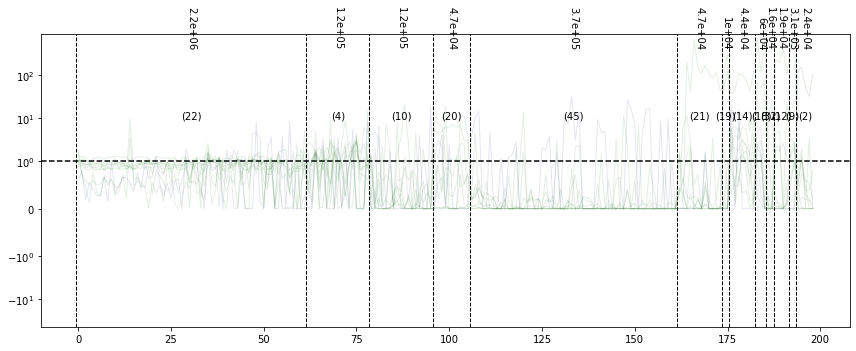

In [84]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [85]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-86-6e12931b1bbb>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


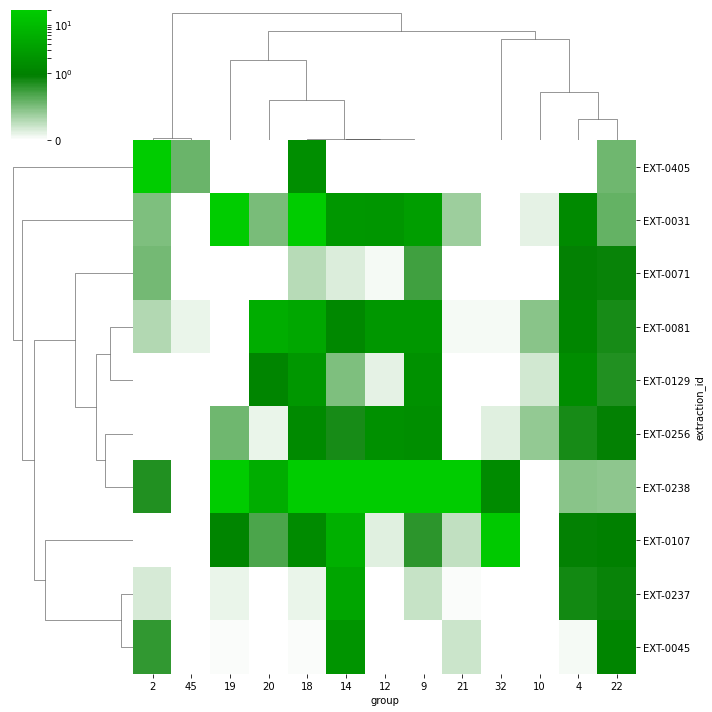

In [86]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

sns.clustermap(d, vmin=vmin, vmax=vmax,
               col_cluster=True, robust=True, cmap=cmap, norm=norm, metric='cosine')


#### Curation

In [87]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

with open('chkpt/core.a.mags/B6.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([22, 4])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B6.g.library.list', 'w') as handle:
    extraction_ids = set(trusted_extractions)
    extraction_ids -= set(['EXT-0405', 'EXT-0238', 'EXT-0045'])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B6.g.trusted_depth.tsv', sep='\t', header=False)

### B7 / OTU-30 / Otu0017

In [88]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/5
otus = ['Otu0017_1']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin00405', 'bin00818', 'bin00941', 'bin01315', 'bin00599', 'bin00873', 'bin00224', 'bin01509', 'bin01727', 'bin01539', 'bin00280', 'bin01563', 'other', 'bin00042', 'bin01487', 'bin00431', 'bin01904', 'bin00417', 'bin00736', 'bin01389', 'bin00789', 'bin00919', 'bin01470', 'bin00959', 'bin01948', 'bin00683', 'bin00461', 'bin00608', 'bin01568', 'bin01189', 'bin00473', 'bin00840', 'bin00535', 'bin01469', 'bin01662', 'bin01964', 'bin00374', 'bin01992', 'bin00044', 'bin00646', 'bin01660', 'bin01027', 'bin00586', 'bin01192', 'bin00483', 'bin01659', 'bin00629', 'bin01439', 'bin01327'}


In [89]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [90]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0017_1
site,
UM,0.000008
UT,0.008662


In [91]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin00280'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
1819450,bin00280,316771
988141,bin00280,244325
864186,bin00280,165325
50754,bin00280,147666
698597,bin00280,134401
1776704,bin00280,124530
814391,bin00280,96704
758698,bin00280,90939
287039,bin00280,87293


#### Normalization

60 trusted contigs and 9 trusted extractions identified


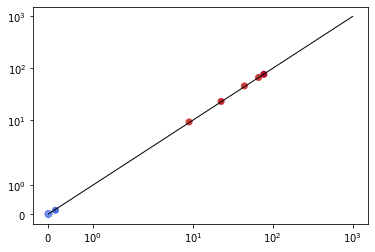

In [92]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '1819450', '988141',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


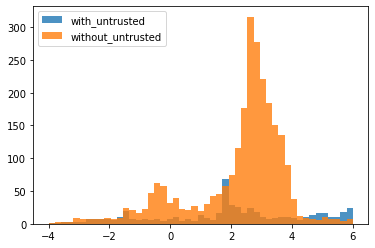

In [93]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-94-412ae0e5a332>:60: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


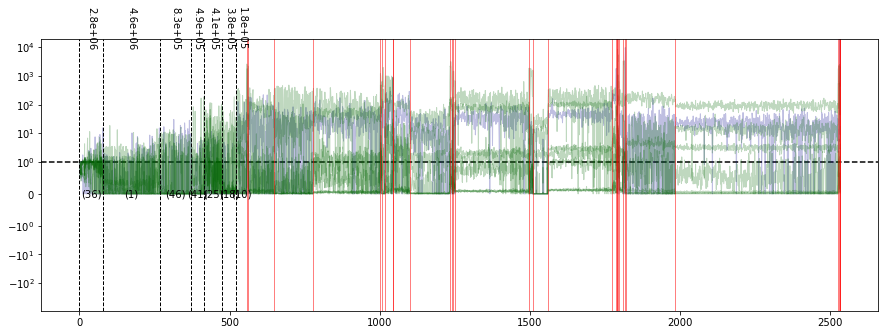

In [94]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=50,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 20
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)


    ax.set_yscale('symlog', linthreshy=1)

In [95]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,1,10,18,25,36,41,46,contam
bin_id,,,,,,,,
bin00042,0,0,0,0,0,0,0,8218
bin00044,11143,0,21063,2825,9608,2200,0,8025
bin00224,0,0,0,0,0,0,0,61643
bin00280,0,0,58509,58514,2729797,4392,22179,56958
bin00374,0,0,0,0,0,0,0,132379
bin00405,0,0,0,0,0,0,20469,0
bin00417,0,0,0,0,0,2656,0,93136
bin00431,129950,0,0,33005,0,0,0,0
bin00461,0,0,0,0,0,98431,0,0


In [96]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UM    control      1
UT    acarbose     5
      control      3
Name: 1002826, dtype: int64


site              UM         UT          
treatment    control   acarbose   control
group                                    
1           0.813814   0.267094  0.928810
10         25.108795  19.299005  1.341136
18          0.471840   1.186858  5.734312
25          1.126072   4.129918  8.382416
36          1.021149   0.969827  0.975630
41          0.438967   3.075159  0.062424
46          2.966977   0.197419  1.716261

<ipython-input-97-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-97-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


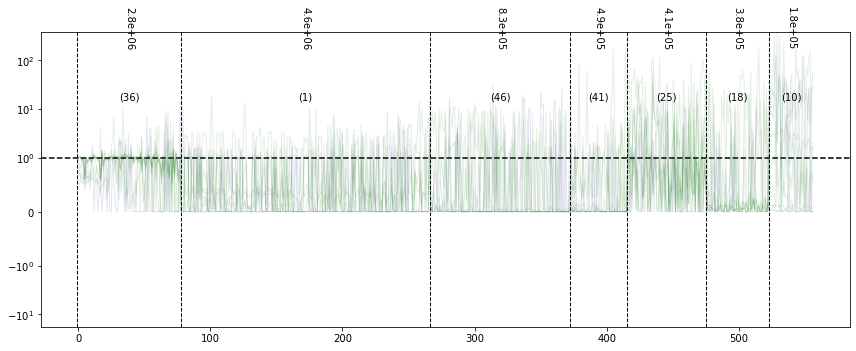

In [97]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [98]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-99-3938c979003a>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
<ipython-input-99-3938c979003a>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,
<ipython-input-99-3938c979003a>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[extraction_meta.site == 'UM']


group,1,18,25,36
extraction_id,,,,
EXT-0405,0.0,0.0,0.0,0.0


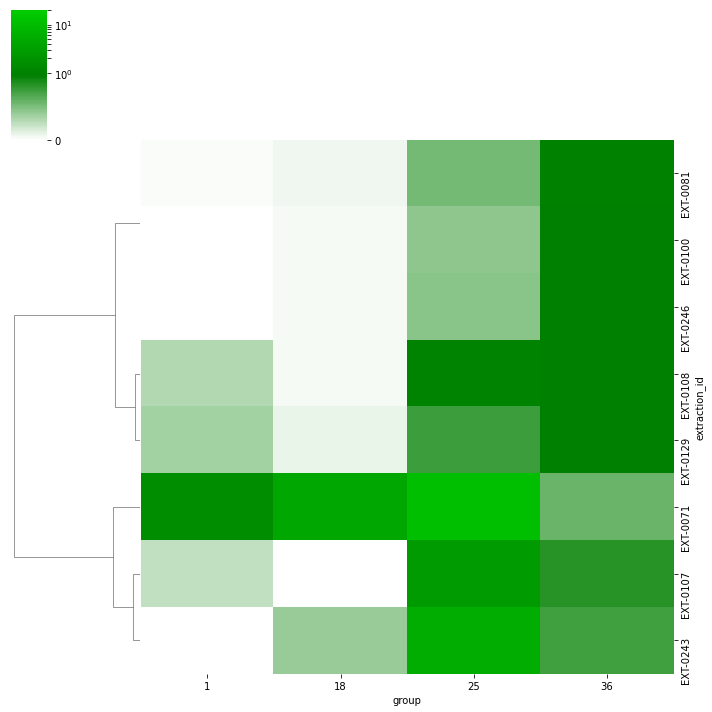

In [99]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[46, 41, 10])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

# sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
#                col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d[extraction_meta.site == 'UT'], vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm, metric='cosine')
d[extraction_meta.site == 'UM']

#### Curation

In [100]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

# UT Strain
with open('chkpt/core.a.mags/B7.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([36, 25])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B7.g.library.list', 'w') as handle:
    extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UT'].index))
    extraction_ids -= set([])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B7.g.trusted_depth.tsv', sep='\t', header=False)

<ipython-input-100-32cfc601e655>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  extraction_ids = set(list(cvrg_norm[extraction_meta.site == 'UT'].index))


## B8 / OTU-11 / Otu0013

In [101]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/2
otus = ['Otu0013_1']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin01611', 'other', 'bin00431', 'bin00599', 'bin01778', 'bin00882', 'bin01499', 'bin01659', 'bin00926', 'bin00629', 'bin00919', 'bin00543'}


In [102]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [103]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0013_1
site,
UM,0.00000
UT,0.00505


In [104]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin00599'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
766897,bin00599,98426
2518556,bin00599,91112
983328,bin00599,86763
60488,bin00599,82190
1667638,bin00599,81277
1677271,bin00599,68694
429403,bin00599,65962
1325884,bin00599,63983
946472,bin00599,59461


#### Normalization

78 trusted contigs and 12 trusted extractions identified


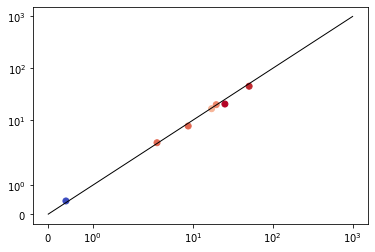

In [105]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '766897', '2518556',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


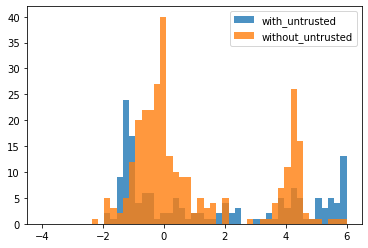

In [106]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-107-08ac91d397b3>:60: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


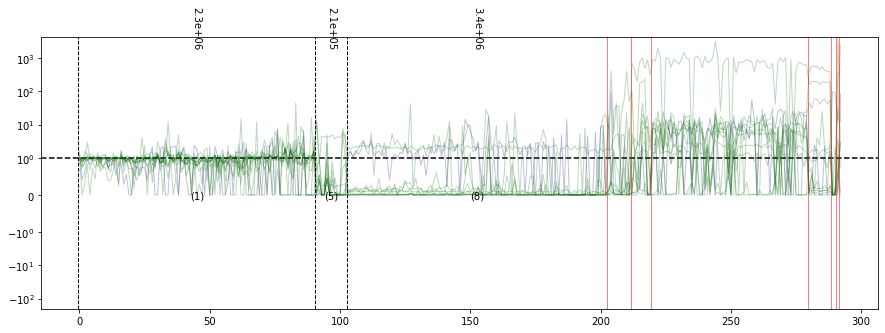

In [107]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=10,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 20
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)


    ax.set_yscale('symlog', linthreshy=1)

In [108]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,1,5,8,contam
bin_id,,,,
bin00431,0,162955,0,0
bin00543,0,0,198915,3560
bin00599,2185141,49044,0,29205
bin00629,0,0,0,130690
bin00882,0,0,17279,0
bin00919,0,0,0,6154
bin00926,0,0,2731826,83646
bin01499,0,0,0,209062
bin01611,0,0,0,176740


In [109]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UM    acarbose     1
UT    acarbose     5
      control      6
Name: 1005536, dtype: int64


site             UM        UT          
treatment  acarbose  acarbose   control
group                                  
1          0.948260  1.070198  1.159123
5          0.063453  0.320211  1.348555
8          2.300609  0.561209  0.625853

<ipython-input-110-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-110-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


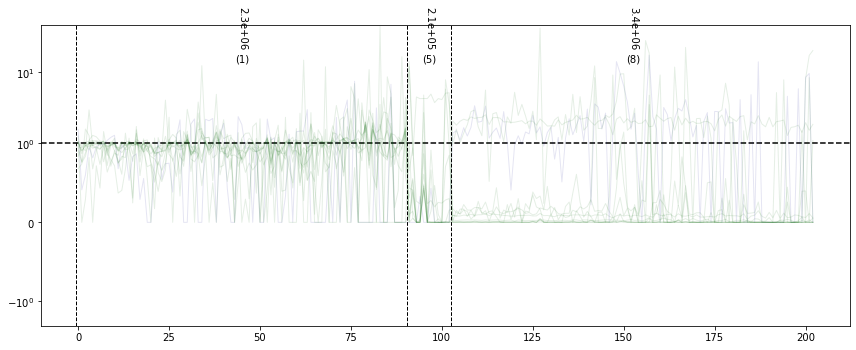

In [110]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [111]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-112-183e99fc05df>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


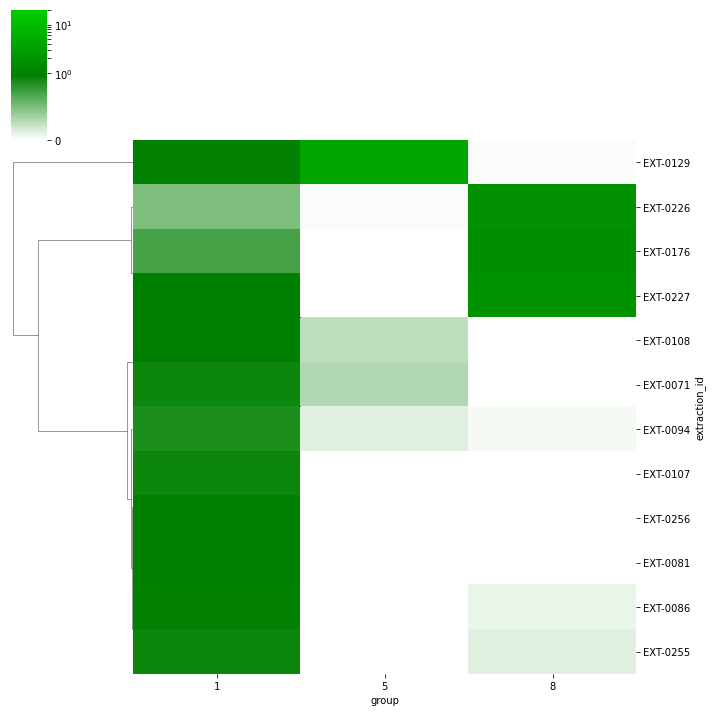

In [112]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

# sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
#                col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d, vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm, metric='cosine')

#### Curation

In [113]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

with open('chkpt/core.a.mags/B8.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([1])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B8.g.library.list', 'w') as handle:
    extraction_ids = set(trusted_extractions)
    extraction_ids -= set([])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B8.g.trusted_depth.tsv', sep='\t', header=False)

## B9 / OTU-? / Otu0105

In [114]:
# INSTRUCTION: Select the closely related OTUs to pool together.
# INSTRUCTION: Pick a *keep_thresh_factor* to choose the bins associated with these OTUs that
# will be considered below.

keep_thresh_factor = 1/2
otus = ['Otu0105_1']
bins = set()
for otu in otus:
    max_contrib = bin_otu_contrib[otu].max()
    bins |= set(bin_otu_contrib[otu][lambda x: x > max_contrib * keep_thresh_factor].index)
    
print(bins)
contig_ids = set(contig_bin[lambda x: x.bin_id.isin(bins)].index)

{'bin01177', 'bin01426', 'bin00232', 'bin01440', 'bin00253', 'bin00629', 'bin01675', 'bin01828', 'bin01366', 'bin00991', 'bin01738', 'bin01877', 'bin00767', 'bin01092', 'bin01192', 'bin00018', 'bin00573', 'bin01279', 'bin00344'}


In [115]:
contig_ids_sql = '"' + '", "'.join(contig_ids) + '"'

cvrg = pd.read_sql("""
SELECT extraction_id, contig_id, SUM(coverage) AS coverage
FROM contig_coverage
JOIN library USING (library_id)
WHERE contig_id IN ({})
GROUP BY extraction_id, contig_id
                   """.format(contig_ids_sql), con=con,
                   index_col=['extraction_id', 'contig_id']).coverage.unstack('contig_id', fill_value=0)

extraction_meta = pd.read_sql("""
SELECT *
FROM extraction
JOIN sample USING (sample_id)
JOIN mouse USING (mouse_id)
JOIN (SELECT extraction_id, SUM(mapping_count) AS mapping_count
      FROM library_total_nucleotides_mapping
      JOIN library USING (library_id)
      GROUP BY extraction_id) USING (extraction_id)
                               """, con=con, index_col='extraction_id')

contig_meta = pd.read_sql("""
SELECT *
FROM contig_bin
JOIN contig USING (contig_id)
WHERE contig_id IN ({})
                          """.format(contig_ids_sql),
                         con=con, index_col='contig_id')

#cvrg = cvrg.div(extraction_meta.coverage, axis=0).loc[d_rabund.index]
cvrg = cvrg.loc[d_rabund.index]

In [116]:
(rabund
     .rename(columns=phylotype.name)
     .groupby(extraction_meta.site)
     [otus]
     .mean())

sequence_id,Otu0105_1
site,
UM,0.000000
UT,0.003834


In [117]:
# INSTRUCTION: Select a *bin_id* to help picking a seed contig.

contig_meta[lambda x: x.bin_id == 'bin00573'].sort_values('length', ascending=False).head(10)

,bin_id,length
contig_id,,
588300,bin00573,301901
202780,bin00573,185743
969487,bin00573,174811
3036009,bin00573,171118
15529,bin00573,150473
2881260,bin00573,144827
2814394,bin00573,140672
1902713,bin00573,139017
228923,bin00573,138298


#### Normalization

117 trusted contigs and 11 trusted extractions identified


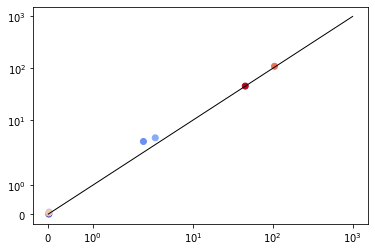

In [118]:
# INSTRUCTION: Select a *seed* contig whose coverage seems to best reflect the relative
# abundance of the OTUs of interest and find a second contig with matching coverage
# to *compare* as a double-check.
# INSTRUCTION: Select *trusted_contigs* threshold that selects the contigs used to normalize coverage.
# INSTRUCTION: Select *trusted_extractions* threshold that selects the extractions to be considered below.

seed, compare = '588300', '1679634',
assert seed in contig_ids
assert compare in contig_ids
plt.scatter(seed, compare, c='rabund',
            data=d_rabund[otus].sum(1).to_frame(name='rabund').join(cvrg).sort_values('rabund'),
            cmap='coolwarm',
            norm=mpl.colors.LogNorm())
plt.plot([0, 1e3], [0, 1e3], c='k', lw=1, scalex=False, scaley=False)
plt.yscale('symlog')
plt.xscale('symlog')

contig_thresh = 0.99
extract_thresh = 0.5

trusted_contigs = cvrg.apply(lambda x: sp.stats.pearsonr(cvrg[seed], x)[0])[lambda x: x > contig_thresh].index

trusted_extractions = (cvrg[trusted_contigs].mean(1) / cvrg[trusted_contigs].std(1))[lambda x: x > extract_thresh].index

print('{} trusted contigs and {} trusted extractions identified'.format(len(trusted_contigs), len(trusted_extractions)))


/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


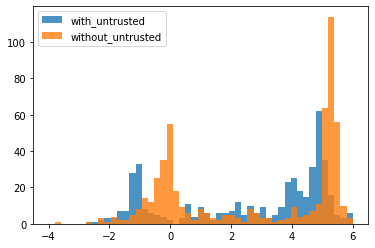

In [119]:
cvrg_norm = cvrg.div(cvrg[trusted_contigs].mean(1), axis=0)
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='with_untrusted', alpha=0.8)
cvrg_norm = cvrg_norm.loc[trusted_extractions]
_ = plt.hist(np.log(cvrg_norm.mean()), bins=np.linspace(-4, 6), label='without_untrusted', alpha=0.8)
plt.legend()

#### Clustering

<ipython-input-120-a3df2df58a36>:60: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


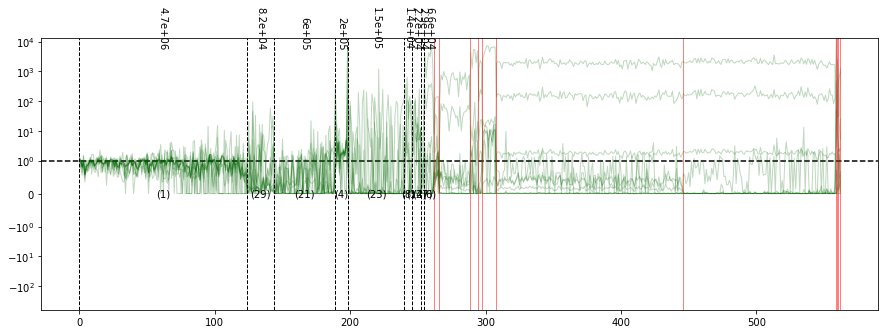

In [120]:
# INSTRUCTION: Select the *n_components* (usually between 10 and 100) to best resolve the contigs into groups.
# INSTRUCTION: Pick a *contam_threshold* that excludes as many groups as possible without excluding any that
# should be included.

cluster_data = np.sqrt(cvrg_norm)

bgm = BayesianGaussianMixture(n_components=30,
                              covariance_type='diag',
#                              weight_concentration_prior_type='dirichlet_distribution',
#                              weight_concentration_prior=10,
                              random_state=1,
                             ).fit(cluster_data.T)
_group_assign = pd.Series(bgm.predict(cluster_data.T), index=cvrg_norm.columns)
group_cvrg = cvrg_norm.groupby(_group_assign, axis='columns').mean().mean().to_frame(name='group_mean_mean_coverage')
group_cvrg['group_mean_std_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').std().mean()
group_cvrg['group_std_mean_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').mean().std()
group_cvrg['group_max_coverage'] = cvrg_norm.groupby(_group_assign, axis='columns').max().max()
group_cvrg['total_length'] = contig_meta.groupby(_group_assign).length.sum()
group_cvrg['contamination_score'] = group_cvrg.group_std_mean_coverage / group_cvrg.group_mean_std_coverage * np.log(group_cvrg.total_length)
group_cvrg.index.name = 'group'
group_assign = _group_assign.to_frame(name='group').join(group_cvrg, on='group')
group_assign['bin_id'] = contig_meta.bin_id
group_assign['length'] = contig_meta.length
group_assign.sort_values(['contamination_score', 'length'], ascending=[True, False], inplace=True)
# order = group_assign.index

fig, ax = plt.subplots(figsize=(15, 5))
ax.axhline(y=1, color='k', linestyle='--')

for des, d in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
#    color = None
    _ = ax.plot(d[group_assign.index].values.T, lw=1, alpha=0.25, color=color)
#_ = ax.plot(group_assign.group_mean_coverage.values, color='k')

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)

group_assign['contig_index'] = range(group_assign.shape[0])
group_order = \
    (group_assign.groupby('group').contig_index
                         .apply(lambda x: pd.Series({'middle': x.mean(),
                                                     'left': x.min(),
                                                     'right': x.max()}))).unstack().sort_values('left')
contam_threshold = 50
for inx, d in group_order.iterrows():
    if group_cvrg.loc[inx].contamination_score > contam_threshold:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    elif group_cvrg.loc[inx].isna().contamination_score:
        ax.axvline(d.left - 0.5, color='r', lw=0.5)
        continue
    else:
        ax.axvline(d.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d.middle, cvrg_norm.min().min()-1e-1), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg.loc[inx].total_length),
                xy=(d.middle, cvrg_norm.max().max() * 0.5),
                ha='center', rotation=-90)


    ax.set_yscale('symlog', linthreshy=1)

In [121]:
a = (group_assign
         [lambda x: x.group.isin(group_cvrg[lambda x: x.contamination_score < contam_threshold].index)]
         .groupby(['bin_id', 'group']).length.sum().unstack(fill_value=0))
b = (group_assign
                   [lambda x: x.group.isin(group_cvrg[lambda x: ( x.contamination_score > contam_threshold)
                                                                | x.contamination_score.isna()
                                                     ].index)]
                   .groupby('bin_id').length.sum())
b.name = 'contam'
a.join(b, how='outer').fillna(0).astype(int)

,1,4,6,8,14,21,23,27,29,contam
bin_id,,,,,,,,,,
bin00018,0,0,0,0,0,98669,0,0,0,0
bin00232,0,0,0,0,0,134586,0,0,0,0
bin00253,0,0,21525,0,0,0,0,0,0,660091
bin00344,0,0,4768,0,0,0,0,0,0,45593
bin00573,4688008,180953,0,14398,20958,45008,151949,0,33526,26351
bin00629,0,0,0,0,1459,0,0,0,0,129231
bin00767,0,0,38930,0,0,0,0,0,0,351376
bin00991,0,0,0,0,0,0,0,0,22087,44444
bin01092,0,0,1270,0,0,0,0,0,0,58778


In [122]:
print(cvrg_norm.groupby([extraction_meta.site, extraction_meta.treatment]).count().iloc[:,0])

(cvrg_norm.groupby(group_assign.group, axis='columns').mean()
          .groupby([extraction_meta.site, extraction_meta.treatment]).mean()).loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index].T

site  treatment
UT    acarbose     5
      control      6
Name: 1002789, dtype: int64


site               UT            
treatment    acarbose     control
group                            
1            0.930021    0.920285
4          144.432060  103.907112
6           49.114263  568.488926
8           31.382132   24.480939
14          14.805230    6.817019
21           0.596105    0.550461
23          15.863378    2.159078
27           0.473963    1.235647
29           3.379696    1.316051

<ipython-input-123-5c9a2d4116ea>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
<ipython-input-123-5c9a2d4116ea>:29: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=1)


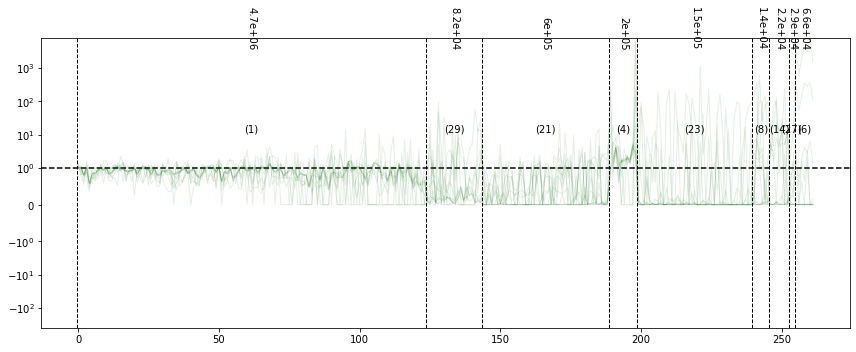

In [123]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.axhline(y=1, color='k', linestyle='--')
artists = []
plotting_order = []
for des, d0 in cvrg_norm.groupby(extraction_meta.site):
    color = color_map[des]
    des_artists = ax.plot(d0[group_assign[lambda x: x.contamination_score < contam_threshold].index].values.T,
                          lw=1, alpha=0.1, color=color)
    artists.extend(des_artists)
    plotting_order.extend(d0.index)
#original_colors = {a: a.get_color() for a in artists}
original_lw = {a: a.get_linewidth() for a in artists}
original_alpha = {a: a.get_alpha() for a in artists}
original_zorder = {a: a.get_zorder() for a in artists}
otu_rabund = [d_rabund.loc[extraction_id][otus].sum() for extraction_id in plotting_order]

group_cvrg_included = group_cvrg.loc[group_order.index][group_cvrg.contamination_score < contam_threshold]
group_order_included = group_order.loc[group_cvrg_included.index]

for inx, d1 in group_order_included.iterrows():
    ax.axvline(d1.left - 0.5, color='k', lw=1, linestyle='--')
    ax.annotate('({})'.format(inx), xy=(d1.middle, group_cvrg_included.group_max_coverage.min()), ha='center')
    ax.annotate('{:0.02}'.format(group_cvrg_included.loc[inx].total_length),
                xy=(d1.middle, group_cvrg_included.group_max_coverage.max() * 0.5),
                ha='center', rotation=-90)

annot = ax.annotate('', xy=(0.02, 0.8), xycoords="axes fraction", rotation=90)
ax.set_yscale('symlog', linthreshy=1)
fig.tight_layout()

def _init():
    return artists

def _animate(i):
    j = i - 1
    artists[i].set_linewidth(1)
    artists[i].set_alpha(0.9)
    artists[i].set_zorder(999)
    artists[j].set_linewidth(original_lw[artists[j]])
    artists[j].set_alpha(original_alpha[artists[j]])
    artists[j].set_zorder(original_zorder[artists[j]])
    annot.set_text('{} ({:0.1f}%)'.format(plotting_order[i], otu_rabund[i]*100))
    return [artists[i], artists[j], annot]

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=cvrg_norm.shape[0], interval=200, blit=True)

In [124]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

colors = [(1, 1, 1), (0, 0.5, 0), (0, 0.8, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

<ipython-input-125-183e99fc05df>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)
/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


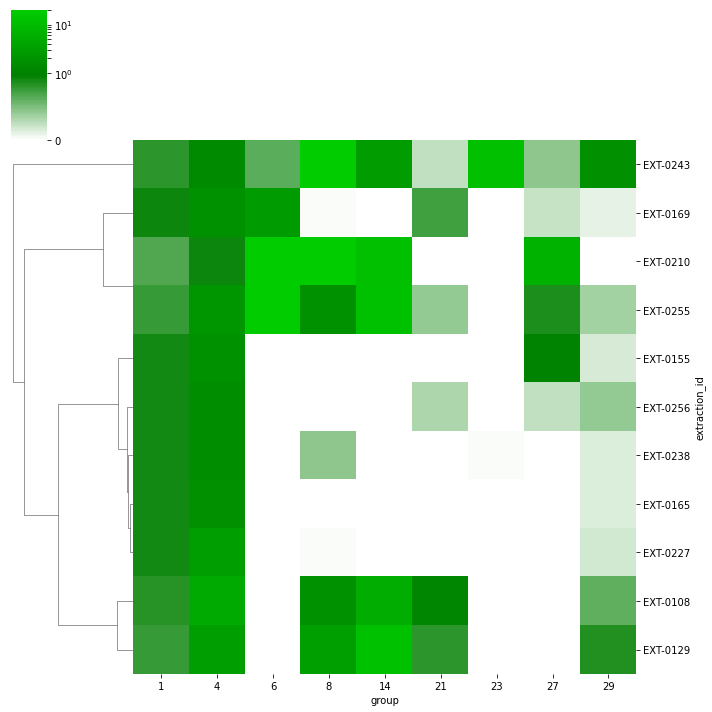

In [125]:
# INSTRUCTION: Pick groups you want to drop from visualization.

d = (cvrg_norm.groupby(group_assign.group, axis='columns').median()
              .loc[:, group_cvrg[lambda x: x.contamination_score < contam_threshold].index]
     .drop(columns=[])
    )

vmin, vmax, cmap, norm = 0, 20, cm, SymLogNorm(linthresh=1, linscale=2)

# sns.clustermap(d[extraction_meta.site == 'UM'], vmin=vmin, vmax=vmax,
#                col_cluster=False, robust=True, cmap=cmap, norm=norm)
sns.clustermap(d, vmin=vmin, vmax=vmax,
               col_cluster=False, robust=True, cmap=cmap, norm=norm, metric='cosine')

#### Curation

In [126]:
# INSTRUCTION: Pick curated contig groups and extractions for each MAG.

with open('chkpt/core.a.mags/B9.g.contigs.list', 'w') as handle:
    for contig_id in group_assign[lambda x: x.group.isin([1, 4])].index:
        print(contig_id, file=handle)
with open('chkpt/core.a.mags/B9.g.library.list', 'w') as handle:
    extraction_ids = set(trusted_extractions)
    extraction_ids -= set([])
    for library_id in library[library.extraction_id.isin(extraction_ids)].index:
        print(library_id, file=handle)
library.join(cvrg, on='extraction_id')[trusted_contigs].sum(1).to_csv('chkpt/core.a.mags/B9.g.trusted_depth.tsv', sep='\t', header=False)